In [1]:
import numpy as np
import os
import pandas as pd
import xgboost as xgb

In [2]:
import sys
sys.path.append('/home/kinho.lo/.local/lib/python3.9/site-packages/')

In [3]:
base_dir = 'storage/output/220314_baseline/'

In [4]:
best_hyperparams = {
    'colsample_bytree': 0.7043247958335778, 
    'gamma': 7.974861069683089, 
    'learning_rate': 0.6552157847578922, 
    'max_depth': 6, 
    'min_child_weight': 7.0, 
    'reg_alpha': 98.0, 
    'reg_lambda': 0.42852084822973424,
}

In [5]:
best_hyperparams = None

In [6]:
%%time
trn_df = pd.read_csv(base_dir+'trn_df.csv').sort_values('customer_id').reset_index()
val_df = pd.read_csv(base_dir+'val_df.csv').sort_values('customer_id').reset_index()

CPU times: user 11.1 s, sys: 1.07 s, total: 12.2 s
Wall time: 12.4 s


In [7]:
%%time
from utils import x_y_group
features = [c for c in trn_df.columns if c not in ['article_id','customer_id','label','index']]
label = 'label'
trn_x,trn_y,trn_grp = x_y_group(trn_df,features,label)
val_x,val_y,val_grp = x_y_group(val_df,features,label)

CPU times: user 1.5 s, sys: 162 ms, total: 1.66 s
Wall time: 1.66 s


In [8]:
%%time
if best_hyperparams is None:
    from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

    space = {
        'objective': 'rank:map',
        'max_depth': hp.choice("max_depth",np.arange(3, 10, dtype=int) ),
        'gamma': hp.uniform ('gamma', 1,9),
        'learning_rate': hp.uniform('learning_rate',0.1,1.0),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 180,
        'seed': 0,
        'eval_metric':'map@12',
    }

    def objective(space):
        model = xgb.XGBRanker(**space)
        model.fit(
            trn_x, trn_y, trn_grp, verbose=True,
            eval_set=[(val_x, val_y)], eval_group=[val_grp],
            early_stopping_rounds=5,
        )
        print ("SCORE:", model.best_score)
        return {'loss': 1.-model.best_score,'status': STATUS_OK}

    trials = Trials()
    best_hyperparams = fmin(
        fn = objective,
        space = space,
        algo = tpe.suggest,
        max_evals = 10,
        trials = trials
    )
    print('Best hyperparameters: ',best_hyperparams)

  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

/apps/pytorch/1.8.1/lib/python3.9/site-packages/xgboost/core.py:499: FutureWarning: Pass `group` as keyword args.  Passing these as positional arguments will be considered as error in future releases.
  warnings.warn(



[0]	validation_0-map@12:0.03088                       
[1]	validation_0-map@12:0.07121                       
[2]	validation_0-map@12:0.07121                       
[3]	validation_0-map@12:0.07235                       
[4]	validation_0-map@12:0.07235                       
[5]	validation_0-map@12:0.07235                       
[6]	validation_0-map@12:0.07235                       
[7]	validation_0-map@12:0.07240                       
[8]	validation_0-map@12:0.07240                       
[9]	validation_0-map@12:0.07240                       
[10]	validation_0-map@12:0.07240                      
[11]	validation_0-map@12:0.07240                      
[12]	validation_0-map@12:0.07240                      
SCORE:                                                
0.072398                                              
[0]	validation_0-map@12:0.03088                                       
[1]	validation_0-map@12:0.03088                                       
[2]	validation_0-map@12:0.07216  

In [9]:
%%time
xgb_config = {    
    'objective': 'rank:map',
    'n_estimators': 180,
    'seed': 0,
    'eval_metric':'map@12',
}
for k,v in best_hyperparams.items():
    xgb_config[k] = v

model = xgb.sklearn.XGBRanker(**xgb_config)
es = xgb.callback.EarlyStopping(
    rounds=5,
    save_best=True,
)
model.fit(
    trn_x, trn_y, trn_grp, verbose=True,
    eval_set=[(val_x, val_y)], eval_group=[val_grp],
    early_stopping_rounds=5,
    callbacks=[es],
)

[0]	validation_0-map@12:0.03088
[1]	validation_0-map@12:0.07217
[2]	validation_0-map@12:0.08058
[3]	validation_0-map@12:0.08348
[4]	validation_0-map@12:0.08348
[5]	validation_0-map@12:0.08348
[6]	validation_0-map@12:0.08348
[7]	validation_0-map@12:0.08566
[8]	validation_0-map@12:0.08566
[9]	validation_0-map@12:0.08566
[10]	validation_0-map@12:0.08566
[11]	validation_0-map@12:0.08566
[12]	validation_0-map@12:0.08566
CPU times: user 28.6 s, sys: 308 ms, total: 28.9 s
Wall time: 7.24 s


XGBRanker(base_score=0.5, booster='gbtree', colsample_bylevel=1,
          colsample_bynode=1, colsample_bytree=0.6750375434063147,
          enable_categorical=False, eval_metric='map@12',
          gamma=3.218519182140094, gpu_id=-1, importance_type=None,
          interaction_constraints='', learning_rate=0.6764113439123965,
          max_delta_step=0, max_depth=4, min_child_weight=1.0, missing=nan,
          monotone_constraints='()', n_estimators=180, n_jobs=4,
          num_parallel_tree=1, objective='rank:map', predictor='auto',
          random_state=0, reg_alpha=147.0, reg_lambda=0.6134604203712706,
          scale_pos_weight=None, seed=0, subsample=1, tree_method='exact',
          validate_parameters=1, ...)

In [10]:
def make_prediction(model,test_df,features,label,k=12):
    test_x,_,_ = x_y_group(test_df,features,label,only_x=True)
    test_pred = model.predict(test_x)
    test_x['customer_id'] = test_df['customer_id']
    test_x['article_id'] = test_df['article_id']
    test_x['prediction'] = test_pred
    pred_df = test_x.groupby('customer_id') \
                    .apply(lambda x: x.sort_values('prediction',ascending=False)['article_id'].tolist()[:k]) \
                    .reset_index()
    pred_df.columns = ['customer_id','prediction']
    return pred_df

def evaluate_score(pred_df,gt_df,k=12):
    from metric import mapk
    eval_df = gt_df.merge(pred_df,on='customer_id')
    print('map@'+str(k), mapk(eval_df['ground_truth'].tolist(),eval_df['prediction'].tolist()))

In [11]:
%%time
test_df = pd.read_csv(base_dir+'test_df.csv').sort_values('customer_id').reset_index()

CPU times: user 18.2 s, sys: 2.06 s, total: 20.3 s
Wall time: 20.8 s


In [12]:
%%time
pred_df = make_prediction(model,test_df,features,label,k=12)

/scratch/local/21234159/ipykernel_42302/1806009743.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_x['customer_id'] = test_df['customer_id']
/scratch/local/21234159/ipykernel_42302/1806009743.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_x['article_id'] = test_df['article_id']


CPU times: user 1min 29s, sys: 1.12 s, total: 1min 31s
Wall time: 1min 28s


In [13]:
%%time
from random import shuffle
def shuffle_list(x):
    shuffle(x)
    return x
random_df = val_df.groupby('customer_id')['article_id'] \
                    .agg(lambda x: shuffle_list(x.tolist())).to_frame().reset_index() \
                    .rename(columns={'article_id':'prediction'})

CPU times: user 3.3 s, sys: 72 ms, total: 3.37 s
Wall time: 3.37 s


In [14]:
%%time
gt_df = pd.read_csv(base_dir+'gt_df.csv')
gt_df['ground_truth'] = gt_df['ground_truth'].apply(lambda x: eval(x))
print('Score with XGBRanker:')
evaluate_score(pred_df,gt_df)
print('Score with random:')
evaluate_score(random_df,gt_df)

Score with XGBRanker:
map@12 0.012769226589314701
Score with random:
map@12 0.00831537822823011
CPU times: user 845 ms, sys: 29 ms, total: 874 ms
Wall time: 1.03 s


In [15]:
def plot_feature_importance(model,out_dir=None,saved_fig_name='feature_importance.png'):
    import matplotlib.pyplot as plt
    plt.tight_layout()
    d = model.get_booster().get_score(importance_type='gain')
    s = pd.Series(d.values(), index=d.keys())
    ax = s.plot(kind='barh')
    fig = ax.get_figure()
    if out_dir is not None: fig.savefig(os.path.join(out_dir,saved_fig_name),bbox_inches = "tight")

def save_xgb_model(model,out_dir,saved_model_name='model.bin'):
    os.makedirs(out_dir,exist_ok=True)
    model.save_model(os.path.join(out_dir,saved_model_name))
    plot_feature_importance(model,out_dir)

/apps/pytorch/1.8.1/lib/python3.9/site-packages/xgboost/sklearn.py:585: UserWarning: max_depth is not saved in Scikit-Learn meta.
  warnings.warn(str(k) + ' is not saved in Scikit-Learn meta.', UserWarning)


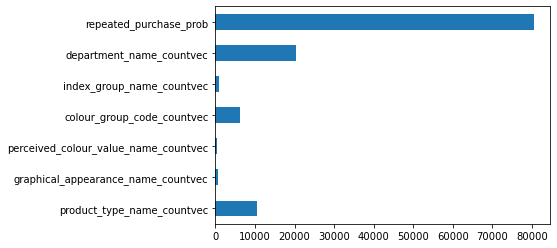

In [16]:
save_xgb_model(model,base_dir)